In [76]:
''' This code implements the set of algorithms described in Section 5 from http://www.columbia.edu/~as5001/strategicclustering.pdf in order to find the next point in the fairness/utility-quality trade-off curve.'''
import networkx as nx
import csv 
import numpy as np
import random
import copy
import math 
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import pairwise_distances
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import pickle
import scipy

In [77]:
# the function cluster_proportions() computes the proportions of different communities in each cluster; 
# the community affiliation of a node is embedded in a graph attribute called 'color' ('b' for majority, 'r' for minority); for using the real data, embed as such.
def cluster_proportions(G, list_nodes_G, no_clusters, cluster_assignment):
    # sizes of clusters                                                                                                    
    unique, counts = np.unique(cluster_assignment, return_counts=True)
    cluster_sizes = dict(zip(unique, counts))
    # cluster_proportion is a dictionary mapping from the clusters to the proportion of the majority nodes in each cluster 
    cluster_proportion = {}
    # cluster_majority is a dictionary mapping from the clusters to the number of the majority nodes in each cluster
    cluster_majority = {}
    # cluster_mminority is a dictionary mapping from the clusters to the number of the minority nodes in each cluster
    cluster_minority = {}
    for kk in range(no_clusters):
        cluster_proportion[kk] = 0
        cluster_majority[kk] = 0
        cluster_minority[kk] = 0

    for u in range(len(list_nodes_G)):
        if G.nodes[list_nodes_G[u]]['color'] == 'b':
            cluster_proportion[cluster_assignment[u]] += 1
            cluster_majority[cluster_assignment[u]] += 1
        else:
            cluster_minority[cluster_assignment[u]] += 1

    for kk in range(no_clusters):
        cluster_proportion[kk] /= cluster_sizes[kk]
    return cluster_sizes, cluster_proportion, cluster_majority, cluster_minority

# the function graph_communities() finds the ratio of majority and minority nodes in the graph
# the community affiliation of a node is embedded in a graph attribute called 'color' ('b' for majority, 'r' for minority); for using the real data, embed as such.
def graph_communities(G, list_nodes_G):
    maj_no = 0
    min_no = 0
    for u in range(len(list_nodes_G)):
        if G.nodes[list_nodes_G[u]]['color'] == 'b':
            maj_no += 1
        else:
            min_no += 1
    return maj_no, min_no


# the function compute_fairness_linear() computes a linear fairness metric defined as abs(#R in cluster - #B in cluster times (1-p)/p), where p = |B| / (|R| + |B|) in the general graph G
def compute_fairness_linear(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    [maj_no, min_no] = graph_communities(G, list_nodes_G)
    maj_prop = maj_no / (maj_no + min_no)
    for kk in range(no_clusters):
        fairness_clusters[kk] = abs(cluster_minority[kk]- cluster_majority[kk]* (1 - maj_prop)/maj_prop)
 
    fairness_overall = np.sum(list(fairness_clusters.values()))
    return fairness_clusters, fairness_overall



# the function compute_fairness_avgprop() computes the average fairness as defined by balance for a clustering as defined in http://proceedings.mlr.press/v97/kleindessner19b.html (avg balance)
def compute_fairness_avgprop(G, list_nodes_G, no_clusters, cluster_assignment):
    fairness_clusters = {}
    [cluster_sizes, cluster_proportion, cluster_majority, cluster_minority] = cluster_proportions(G,list_nodes_G, no_clusters, cluster_assignment)
    [maj_no, min_no] = graph_communities(G, list_nodes_G)
    maj_prop = maj_no / (maj_no + min_no)
    for kk in range(no_clusters):
        fairness_clusters[kk] = abs(cluster_proportion[kk]- maj_prop)
 
    fairness_overall = np.mean(list(fairness_clusters.values()))
    return fairness_clusters, fairness_overall

# computing the incluster degree of nodes, helper function for compute_fairness_avgprop_mfhg and compute_util_avgprop_closeness
def incluster_degree(G, list_nodes_G, cluster_assignment, node):
    degu = 0
    for nbr in G.neighbors(node):
        if cluster_assignment[list_nodes_G.index(node)] == cluster_assignment[list_nodes_G.index(nbr)]:
            degu += 1
    return degu


# the function compute_fairness_avgprop_mfhg() computes the average utility as defined by mfu (https://www.semanticscholar.org/paper/Price-of-Pareto-Optimality-in-Hedonic-Games-Elkind-Fanelli/7764a4ee7d8e0a56c05439a429678d031ce601d4) 
# this utility function is mfu, from Price of Pareto Optimality in hedonic games by elkind et al, namely, w_i(C) / |C| - 1 (or w_i(C)/|C|) where w_i(C) is the sum of utility of node i in cluster C
def compute_util_avgprop_mfhg(G, list_nodes_G, no_clusters, cluster_assignment):
    util_clusters = {}
    for i in range(no_clusters):
        util_clusters[i] = 0
        # indices in cluster i
        cl = np.where(cluster_assignment == i)[0]
        for j in cl: 
            deg_u = incluster_degree(G, list_nodes_G, cluster_assignment, list_nodes_G[j])
            util_clusters[i] += deg_u/ (len(cl) - 1)
    util_overall = np.mean(list(util_clusters.values()))
    return util_clusters, util_overall

# the function compute_util_avgprop_closeness() computes the average utility as defined by the closeness utility, section 3 in http://www.columbia.edu/~as5001/strategicclustering.pdf
def compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment):
    util_clusters = {}
    for i in range(no_clusters):
        util_clusters[i] = 0
        # indices in cluster i
        cl = np.where(cluster_assignment == i)[0]
        for j in cl: 
            lengths_total = nx.single_source_shortest_path_length(G, list_nodes_G[j])
            deg_u = incluster_degree(G, list_nodes_G, cluster_assignment, list_nodes_G[j])
            lengths_j = 0
            for jj in cl:
                if j != jj:
                    lengths_j += lengths_total[list_nodes_G[jj]]
            util_clusters[i] += deg_u/lengths_j
    util_overall = np.mean(list(util_clusters.values()))
    return util_clusters, util_overall

# the function compute_conductance() computes average conductance for a clustering assignment (a metric for 'quality' of clustering in networks)
def compute_avg_conductance(G, list_nodes_G, no_clusters, cluster_assignment):
    conductance = 0
    conductance_clusters = {}
    
    for i in range(no_clusters):
        ll = np.where(cluster_assignment==i)[0].tolist()
        conductance_clusters[i] = nx.conductance(G, ll, list(set(list_nodes_G) - set(ll)))
    conductance = np.mean(list(conductance_clusters.values()))
    return conductance_clusters, conductance

# the function compute_avg_kdistance_cl() computes the average distance to the k-means center obtained from the kmeans algorithm for a specified cluster
# note: k-means doesn't optimize for average, this is just for our own experiments; in general, we use compute_avg_kdistance_cl_inertia defined below 
def compute_avg_kdistance_cl(cluster_assignment, my_cluster, km_distances):
    avgdist = km_distances[np.where(cluster_assignment==my_cluster)][:,my_cluster].mean()
    return avgdist

# the function compute_avg_kdistance() computes the average distance of all clusters to their respective k-means centers obtained from the kmeans algorithm
# note: k-means doesn't optimize for average, this is just for our own experiments; in general, we use compute_avg_kdistance_cl_inertia defined below 
def compute_avg_kdistance(cluster_assignment, no_clusters, km_distances):
    dist_clusters = {}
                                                                                                     
    for kkk in range(no_clusters):
        dist_clusters[kkk] = km_distances[np.where(cluster_assignment==kkk)][:,kkk].mean()
    avgdist = np.mean(list(dist_clusters.values()))
    return dist_clusters, avgdist

# the function compute_avg_kdistance_cl() computes the average distance to the k-means center obtained from the kmeans algorithm for a specified cluster
# note: this is what k-means optimizes for 
def compute_avg_kdistance_cl_inertia(cluster_assignment, my_cluster, km_distances):
    sumdist = km_distances[np.where(cluster_assignment==my_cluster)][:,my_cluster].sum()
    return sumdist

# the function compute_avg_kdistance() computes the average distance of all clusters to their respective k-means centers obtained from the kmeans algorithm
# note: this is what k-means optimizes for 
def compute_avg_kdistance_inertia(cluster_assignment, no_clusters, km_distances):
    dist_clusters = {}
                                                                                                     
    for kkk in range(no_clusters):
        dist_clusters[kkk] = (km_distances[np.where(cluster_assignment==kkk)][:,kkk]).sum()
    sumdist = np.sum(list(dist_clusters.values()))
    return dist_clusters, sumdist

# # the function compute_avg_ncut() computes the normalized cut size between a subgraph S and a graph G
def compute_avg_ncut(G, list_nodes_G, no_clusters, cluster_assignment):
    ncut = 0
    ncut_clusters = {}
                                                                                                    
    for i in range(no_clusters):
        ll = np.where(cluster_assignment==i)[0].tolist()
        ncut_clusters[i] = nx.normalized_cut_size(G, ll, list(set(list_nodes_G) - set(ll)))
    ncut = np.mean(list(ncut_clusters.values()))
    return ncut_clusters, ncut

# the function doubly_weighted_G() creates a transformed doubly-weighted graph from an original inputted graph, where the weights represent the difference fairness/utility and quality, respectively.
def doubly_weighted_G(G,Gnew, list_nodes_G,cluster_assignment,no_clusters, km_distances):
    # use closeness utility
    #[fairness_cl, fairness_all] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
    # use statistical parity
    [fairness_cl, fairness_all] = compute_fairness_linear(G, list_nodes_G, no_clusters, cluster_assignment)
    [distances_cl, distances] = compute_avg_kdistance_inertia(cluster_assignment, no_clusters, km_distances)

    for u in range(len(list_nodes_G)):
        for v in range(len(list_nodes_G)):
            if cluster_assignment[u] != cluster_assignment[v]:
                cluster_assignment_copy = copy.deepcopy(cluster_assignment)
                mycl = cluster_assignment[v]
                # TODO: double check this, don't exchange them just compute the new clustering fairness/quality since you're changing the cluster assignment 
                cluster_assignment_copy[u], cluster_assignment_copy[v] = cluster_assignment[v], cluster_assignment[u]

                # use closeness utility
                #[fairness_cl_new, fairness_all_new] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
                # use statistical parity
                [fairness_cl_new, fairness_all_new] = compute_fairness_linear(G, list_nodes_G, no_clusters, cluster_assignment_copy)
                distances_cl_new = compute_avg_kdistance_cl_inertia(cluster_assignment_copy, mycl, km_distances)

                Gnew.add_edge(list_nodes_G[u],list_nodes_G[v],auv=(fairness_cl_new[mycl]-fairness_cl[mycl]),tuv=distances_cl_new-distances_cl[mycl])
                #cluster_assignment[u], cluster_assignment[v] = cluster_assignment[v], cluster_assignment[u]
    # adding edges from nodes to clusters
    cluster_nodes = list(range(len(G.nodes()),len(G.nodes()) + no_clusters))
    Gnew.add_nodes_from(cluster_nodes)
    for u in range(len(list_nodes_G)):
        for i in range(no_clusters):
            if cluster_assignment[u] != i:
                ucl = cluster_assignment[u]
                cluster_assignment[u] = i
                v = i + len(G.nodes())
                # use closeness utility
                #[fairness_cl_new, fairness_all_new] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
                # use statistical parity
                [fairness_cl_new, fairness_all_new] = compute_fairness_linear(G, list_nodes_G, no_clusters, cluster_assignment)
                distances_cl_new = compute_avg_kdistance_cl_inertia(cluster_assignment, i, km_distances)               
                Gnew.add_edge(list_nodes_G[u],v,auv=(fairness_cl_new[i]-fairness_cl[i]),tuv=distances_cl_new-distances_cl[i])
                cluster_assignment[u] = ucl
    # add node start 
    nn = len(Gnew.nodes())
    Gnew.add_node(nn)

    for j in cluster_nodes:
        Gnew.add_edge(j,nn,auv=0,tuv=0)
        Gnew.add_edge(nn,j,auv=0,tuv=0)

    # TODO: REMOVE THIS: not necessary to have an edge from start to every node
    # for j in range(len(G.nodes())):
        # add an edge from start node to every node with weight equal to the difference if we remove the node from its cluster
    #    mycl2 = cluster_assignment[j]
    #    cluster_assignment[j] = (mycl2 + 1)%no_clusters
        # use closeness utility
        #[fairness_cl_new2, fairness_all_new2] = compute_util_avgprop_closeness(G, list_nodes_G, no_clusters, cluster_assignment)
        # use statistical parity
    #    [fairness_cl_new2, fairness_all_new2] = compute_fairness_linear(G, list_nodes_G, no_clusters, cluster_assignment)
    #    distances_cl_new2 = compute_avg_kdistance_cl_inertia(cluster_assignment, mycl2, km_distances)
    #    Gnew.add_edge(nn,list_nodes_G[j],auv=(fairness_cl_new2[mycl2]-fairness_cl[mycl2]),tuv=distances_cl_new2-distances_cl[mycl2])
    #    cluster_assignment[j] = mycl2
    #for j in range(len(G.nodes()),nn):
    #    Gnew.add_edge(j,nn,auv=0,tuv=0)
    
    return Gnew

# this is the classic Floyd-Warshall algorithm for finding whether there is a negative cycle in t_uv weights
def negCyclefloydWarshall(G,list_nodes_G): 
    V = len(G.nodes())
    # dist[][] will be the 
    # output matrix that will  
    # finally have the shortest  
    # distances between every 
    # pair of vertices  
    #dist=[[0 for i in range(V+1)]for j in range(V+1)] 
    dist=[[0 for i in range(V)]for j in range(V)] 
       
    # Initialize the solution 
    # matrix same as input 
    # graph matrix. Or we can 
    # say the initial values  
    # of shortest distances 
    # are based on shortest  
    # paths considering no 
    # intermediate vertex.  
    for i in range(V): 
        for j in range(V): 
            if [list_nodes_G[i],list_nodes_G[j]] in G.edges():
                dist[i][j] = G[i][j]['tuv'] 
            else:
                dist[i][j] = math.inf
    ''' Add all vertices one 
        by one to the set of  
        intermediate vertices. 
    ---> Before start of a iteration, 
         we have shortest 
        distances between all pairs 
        of vertices such  
        that the shortest distances 
        consider only the 
        vertices in set {0, 1, 2, .. k-1} 
        as intermediate vertices. 
    ----> After the end of a iteration, 
          vertex no. k is  
        added to the set of 
        intermediate vertices and  
        the set becomes {0, 1, 2, .. k} '''
    for k in range(V): 
      
        # Pick all vertices  
        # as source one by one 
        for i in range(V): 
                   
            # Pick all vertices as 
            # destination for the 
            # above picked source 
            for j in range(V): 
          
                # If vertex k is on 
                # the shortest path from 
                # i to j, then update 
                # the value of dist[i][j] 
                if ((dist[i][k] + dist[k][j]) < dist[i][j]): 
                        dist[i][j] = dist[i][k] + dist[k][j] 
   
    # If distance of any 
    # vertex from itself 
    # becomes negative, then 
    # there is a negative 
    # weight cycle. 
    for i in range(V): 
        if (dist[i][i] < 0): 
            return True
   
    return False

# the function create_M_graph() creates a transformed graph with weights a_uv * M - t_uv
def create_M_graph(G,newG, theM):
    myG_M = nx.DiGraph()
    myG_M.add_nodes_from(G)
    auv_var=nx.get_edge_attributes(newG,'auv')
    tuv_var=nx.get_edge_attributes(newG,'tuv')
    for e in newG.edges():
        # note that it is auv + M * tuv, in order to make M positive
        myG_M.add_edge(e[0],e[1],weight=auv_var[e]+theM*tuv_var[e])
    return myG_M

# the function SPFA() implements a faster version of the Floyd-Warshall algorithm for finding negative cycles, without early termination and with cycle termination
def SPFA(G):
    queue = []
    for v in G.nodes():
        length[v] = 0
        dis[v] = 0
        pre[v] = 0
        queue.append(v)
    while len(queue) > 0:
        u = queue.pop(0)
        for (u, v) in G.edges():
            if dis[u] + G[u][v]['weight'] < dis[v]:
                pre[v] = u
                length[v] = length[u] + 1
                if length[v] == len(G.nodes()):
                    return v,pre,"negative cycle detected"
                dis[v] = dis[u] + G[u][v]['weight']
                if v not in queue:
                    queue.append(v)
    return "no negative cycle detected"

# the function Trace() traces the negative cycle from the vertex given by SPFA
def Trace(pre, v):
    mys = []
    while v not in mys:
        mys.append(v)
        v = pre[v]
    cycle = [v]
    while mys[len(mys)-1] != v:
        cycle.append(mys.pop())
    cycle.append(v)
    return cycle

# the function compute_slope() computes the slope of line in Euclidean space
def compute_slope(x1, y1, x2, y2):
    return (float)(y2-y1)/(x2-x1)

# the function SPFA() implements a faster version of the Floyd-Warshall algorithm for finding negative cycles, without early termination and with cycle termination, used only for the t-weights
def SPFA2(G):
    queue = []
    for v in G.nodes():
        length[v] = 0
        dis[v] = 0
        pre[v] = 0
        queue.append(v)
    while len(queue) > 0:
        u = queue.pop(0)
        for (u, v) in G.edges():
            if dis[u] + G[u][v]['tuv'] < dis[v]:
                pre[v] = u
                length[v] = length[u] + 1
                if length[v] == len(G.nodes()):
                    return v,pre,"negative cycle detected"
                dis[v] = dis[u] + G[u][v]['tuv']
                if v not in queue:
                    queue.append(v)
    return "no negative cycle detected"

# the function compute_conductance() computes average conductance for a clustering assignment
def compute_conductance(G, list_of_nodes_G, cluster_assignment, no_of_clusters):
    clconductance = {}
    for i in range(no_of_clusters):
        icl = [list_of_nodes_G[x] for x in list(np.where(cluster_assignment == i)[0])]
        #print(icl)
        if len(icl) == 0 or len(icl) == len(list_of_nodes_G):
            clconductance[i] = 0
        else:
            clconductance[i] = nx.conductance(G,icl)
    if(len([v for v in clconductance.values() if v > 0]) == 0):
        return 0
    else:
        return 1 - sum(clconductance.values())/len([v for v in clconductance.values() if v > 0])

# the function compute_balance is computing average balance of a graph and a clustering as defined by balance for a clustering as defined in http://proceedings.mlr.press/v97/kleindessner19b.html (avg balance)
def compute_balance(G,list_of_nodes_G,cluster_assignment,no_of_clusters, sensitive_info):
   balance_avg = 0
   for cl in range(no_of_clusters):
       
       clind = np.where(cluster_assignment == cl)[0]
       sens0cl = 0
       sens1cl = 0
       for j in clind:
           if sensitive_info[j] == 0:
               sens0cl += 1
           else:
               sens1cl +=1
       if sens0cl == 0 or sens1cl == 0:
           balance_cl = 0
       else:
           balance_cl = min(sens0cl/sens1cl,sens1cl/sens0cl)
       balance_avg += balance_cl
   return balance_avg/no_of_clusters

# the function compute_balancemin is computing min balance of a graph and a clustering as defined by balance for a clustering as defined in http://proceedings.mlr.press/v97/kleindessner19b.html (avg balance)
def compute_balancemin(G,list_of_nodes_G,cluster_assignment,no_of_clusters, sensitive_info):
    balance_min = []
    for cl in range(no_of_clusters):
        clind = np.where(cluster_assignment == cl)[0]
        sens0cl = 0
        sens1cl = 0
        for j in clind:
            if sensitive_info[j] == 0:
                sens0cl += 1
            else:
                sens1cl +=1
        if sens0cl == 0 or sens1cl == 0:
            balance_cl = 0
        else:
            balance_cl = min(sens0cl/sens1cl,sens1cl/sens0cl)
        balance_min.append(balance_cl)
    return min(balance_min)


# this function is a Python-version of the Matlab code of the fair spectral clustering algorithm in http://proceedings.mlr.press/v97/kleindessner19b.html, used for comparing clustering with our own alg
def Fair_SC_normalized(G, adj,no_clusters,sensitive):
    n = np.shape(adj)[1]
    sens_unique = np.unique(sensitive)    
    h = len(sens_unique)
    sensitiveNEW=sensitive.copy()
    
    temp = 0
    
    for ell in sens_unique:
        sensitiveNEW[np.where(sensitive==ell)[0]] = temp
        temp += 1

    F=np.zeros([n,h-1])
    for ell in range(h-1):
        temp = np.where(sensitiveNEW == ell)[0]
        F[temp,ell]=1
        groupSize = len(temp)
        F[:,ell] = F[:,ell]-groupSize/n

    L = nx.normalized_laplacian_matrix(G)
    L.todense()
    D = np.diag(np.sum(np.array(adj.todense()), axis=1))

    _,Z = null(F.transpose())
    zz = ((Z.transpose()).dot(D)).dot(Z)
    Q = scipy.linalg.sqrtm(zz)
    Q = Q.real
    Qinv = np.linalg.inv(Q)
    
    Msymm = ((((Qinv.transpose()).dot(Z.transpose())).dot(L.todense())).dot(Z)).dot(Qinv)
    Msymm = (Msymm+Msymm.transpose())/2
    e,v = np.linalg.eig(Msymm)
    
    i = [list(e).index(j) for j in sorted(list(e))[1:no_clusters]]
    Y = np.array(v[:, i])
    Y = Y.real

    H = (Z.dot(Qinv)).dot(Y)
    
    km_fair = KMeans(init='k-means++', n_clusters=no_clusters, max_iter=200, n_init=200, verbose=0, random_state=3425)
    km_fair.fit(H)
    X_dist_fair = km_fair.transform(H)**2

    clusterLabels = km_fair.labels_
    return clusterLabels

def null(a, rtol=1e-5):
    u, s, v = np.linalg.svd(a)
    rank = (s > rtol*s[0]).sum()
    return rank, v[rank:].T.copy()


In [3]:

# # this code is an example for running a simulated model, generated by the stochastic block model 
# # main function to execute
# if __name__ == "__main__":
#     no_of_iterations = 30
#     #iteration = 0
#     fairness_list = []
#     cost_list = []
#     # this code includes the implementation of a stochastic block model; for reading the real data, please see / modify with the code from section5-nashequilibria-realdatasets.py
#     # sizes of each block, the length of sizes defines the number of blocks
#     sizes = [10, 10, 10, 10, 10]
#     # probability of connections 
#     probs = [[0.7, 0.07, 0.05, 0.03, 0.05], 
#             [0.07, 0.6, 0.1, 0.05, 0.07], 
#             [0.05, 0.1, 0.5, 0.05, 0.1], 
#             [0.03, 0.05, 0.05, 0.6, 0.05], 
#             [0.05, 0.07, 0.1, 0.05, 0.6]]

#     # create the graph based on the stochastic block model
#     G_SBM = nx.stochastic_block_model(sizes, probs)

#     nx.info(G_SBM)
#     list_nodes=list(G_SBM.nodes())

#     # add a label, red or blue, to each node, in a random fashion; 'ratio' is the ratio of the red nodes
#     ratio = 0.3
#     no_red = int(0.3*sum(sizes))
#     no_blue = sum(sizes) - no_red
#     attributes_r = ['r']*no_red
#     attributes_b = ['b']*no_blue
#     attributes = attributes_r + attributes_b
#     random.shuffle(attributes)
#     attributes_dict = {}
#     count = 0
#     for u in G_SBM.nodes():
#         attributes_dict[u] = attributes[count]
#         count += 1
#     nx.set_node_attributes(G_SBM, attributes_dict,'color')

#     # k is the number of clusters for spectral clustering
#     k = len(sizes)
#     # finding the spectrum of the graph
#     A = nx.adjacency_matrix(G_SBM)
#     L = nx.normalized_laplacian_matrix(G_SBM)
#     L.todense()
#     D = np.diag(np.sum(np.array(A.todense()), axis=1))

#     e, v = np.linalg.eig(L.todense())

#     i = [list(e).index(j) for j in sorted(list(e))[1:k]]
#     print(i)

 
#     U = np.array(v[:, i])
#     # performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#     km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
#     km.fit(U)
#     y = km.labels_
#     # distances from the k-centers
#     X_dist = km.transform(U)**2

#     # keeping a copy of the clustering assignment
#     y_copy = copy.deepcopy(y)
#     print(y_copy)

    
#     for iteration in range(no_of_iterations):
#         print("Iteration number: ",iteration)
#         # compute the cost and fairness of this clustering
#         # using closeness utility
#         [_,avgf] = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y)
#         # using statistical parity
#         #[_,avgf] = compute_fairness_avgprop(G_SBM, list_nodes,k,y)
#         print("Average unfairness: ", avgf)  
        
#         fairness_list.append(avgf)
#         [_,avgcost] = compute_avg_kdistance(y,k,X_dist)
#         print("Average cost: ", avgcost)
#         cost_list.append(avgcost)
#         if avgf == 0:
#             break
#         # generating G_new with double weights
#         G_new = nx.DiGraph()
#         G_new.add_nodes_from(G_SBM)
#         G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
#         list_nodes_Gnew = list(G_new.nodes())

#         length = {}
#         dis = {}
#         pre = {} 
#         result = SPFA2(G_new)
#         # assert that G_new does not have a negative t-cycle
#         if len(result) == 3:
#             assert(iteration > 0)

#             my_slope = compute_slope(fairness_list[iteration-1], cost_list[iteration-1], fairness_list[iteration], cost_list[iteration])
#             myM = -1/my_slope
#             epsilon = myM*1e-60
#             print("M and slope:", M, myM)
#             for e in G_new.edges():
#                 G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
#                 G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)

#         length = {}
#         dis = {}
#         pre = {} 
#         newresult = SPFA2(G_new) 

#         if len(newresult) == 3:
#             [vv,pre,stri] = newresult
#             negt = Trace(pre,vv)
#             print(negt)
#             sumcycle = 0
#             for i in range(len(negt) - 1):
#                 sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
#             print("negative t-cycle was not fixed: ", sumcycle)
#             y_neg = np.copy(y)
#             for i in range(len(negt)):
#                 if negt[i] < len(G_SBM.nodes()):
#                     if i == len(negt) - 1:
#                         break
#                     if negt[i+1] < len(G_SBM.nodes()):
#                         y_neg[negt[i]] = y[negt[i+1]]
#                     if negt[i + 1] >= len(G_SBM.nodes()) and negt[i+1] < len(G_SBM.nodes()) + k:
#                         y_neg[negt[i]] = negt[i+1] % len(G_SBM.nodes())
#             _,avgdistneg = compute_avg_kdistance(y_neg, k, X_dist)
#             # using closeness utility
#             _,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
#             # using statistical parity
#             #_,avgfairnessneg = compute_fairness_avgprop(G_SBM, list_nodes,k,y_neg)
#             print("Cost when correcting a negative cycle: ", avgdistneg)
#             print("Fairness when correcting a negative cycle: ", avgfairnessneg)

#             break

#         length = {}
#         dis = {}
#         pre = {} 

#         print("we're finding Mlow")
        
#         Mfind = 1
#         G_M = create_M_graph(G_SBM,G_new, Mfind)
#         mresult = SPFA(G_M)
#         if(len(mresult) != 3):
#             Mfind = 0
#             G_M = create_M_graph(G_SBM,G_new, Mfind)
#             assert(len(SPFA(G_M)) == 3)
#         else:
#             while True:
#                 G_M = create_M_graph(G_SBM,G_new, Mfind)
#                 if SPFA(G_M) == 'no negative cycle detected':
#                     break
#                 Mfind *= 2

#         #print("we found Mlow")
#         # initialize M and the limits for the binary search
#         M = Mfind/2
#         delta = Mfind/2
#         low = Mfind/2
#         high = Mfind

#         # binary search to find M for which there is a cycle of length 0
#         termination_condition = 10e-14
#         mids = []
#         while np.abs(delta) > termination_condition:
#             if high > low: 
#                 mid = (high + low) / 2
#                 mids.append(mid)
#             G_M = create_M_graph(G_SBM,G_new, mid)
#             if SPFA(G_M) == 'no negative cycle detected':
#                 delta = mid - low
#                 high = mid
#             else:
#                 delta = high - mid
#                 low = mid
#         whereinmidsweare = 0
#         for mm in reversed(mids):
#             whereinmidsweare += 1
#             G_M = create_M_graph(G_SBM,G_new, mm)
#             if len(SPFA(G_M)) == 3:
#                break
#         if whereinmidsweare == len(mids):
#             break
#         M=mm
        
#         G_M = create_M_graph(G_SBM,G_new, M)
#         [v,pre,stri]=SPFA(G_M)
#         myc = Trace(pre,v)
#         print("best cycle: ",myc)
#         ytest = np.copy(y)
#         for i in range(len(myc)):
#             print(myc[i])
#             if myc[i] < len(G_SBM.nodes()):
#                 if i == len(myc) - 1:
#                     break
#                 if myc[i+1] < len(G_SBM.nodes()):
#                     #a = y[myc[i]]
#                     ytest[myc[i]] = y[myc[i+1]]
#                 if myc[i + 1] >= len(G_SBM.nodes()) and myc[i+1] < len(G_SBM.nodes()) + k:
#                     print(myc[i+1])
#                     ytest[myc[i]] = myc[i+1] % len(G_SBM.nodes())
#         y = np.copy(ytest)

#     print("Fairness: ", fairness_list)
#     print("Cost: ", cost_list)
#     filename = 'SBM_n' + str(len(list_nodes)) + '_r' + str(ratio) + '_k' + str(k) + 'closeness'
#     f = open('filename','w')
#     writer=csv.writer(f,lineterminator="\n")
#     writer.writerow(fairness_list)
#     writer.writerow(cost_list)
#     f.close()

In [78]:
### the following section reads in one of the datasets: APS, Facebook, Highschool; uncomment for the data desired to use
'''#APS dataset: 
filename = 'APS-clusteringgames-utilities-conductance.csv'

# read in the data as a graph
G_og = nx.read_gexf('Downloads/clustering_plotting/APS/sampled_APS_pacs052030.gexf')

# work with the largest connected compoenent
gg = sorted(nx.connected_components(G_og),key=len,reverse=True)[0]
Gc = G_og.subgraph(gg)

list_nodes=list(Gc.nodes())


# finding the spectrum of the graph
A = nx.adjacency_matrix(Gc)
L = nx.normalized_laplacian_matrix(Gc)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))
e, v = np.linalg.eig(L.todense())
'''

'''#Facebook dataset: 
filename = 'Facebook-clusteringgames-utilities-conductance.csv'

# read in the data as a graph
Gc = nx.read_edgelist('Facebook/facebook_combined.txt')

list_nodes=list(Gc.nodes())

# finding the spectrum of the graph
A = nx.adjacency_matrix(Gc)
L = nx.normalized_laplacian_matrix(Gc)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))
e, v = np.linalg.eig(L.todense())

gender = {}
egos = ['0', '107','348','414','686','698','1684','1912','3437','3980']
genderfeatfinder = {}

# find the sensitive feaures (anonymized gender), and place them in a dictionary
for u in egos: 
    genderfeatfinder[u] = {}
    filenamefeat = 'Facebook/' + u + '.featnames'
    ffeat = open(filenamefeat)
    readerfeat = csv.reader(ffeat)
    for rowfeat in readerfeat:
        myrowfeat = rowfeat[0].split()
        genderfeatfinder[u][myrowfeat[0]] = myrowfeat[1].split(';')[0]
    ffeat.close()
    gender_ind = [k for k,v in genderfeatfinder[u].items() if v == 'gender']
    filenameego= 'Facebook/' + u +'.egofeat'
    fego = open(filenameego)
    readerego =csv.reader(fego)
    for rowego in readerego:
        myrowego = rowego[0].split()
        gender[u] = myrowego[int(max(gender_ind))]
    fego.close()
    filename= 'Facebook/' + u +'.feat'
    f = open(filename)
    reader =csv.reader(f)
    for row in reader:
        myrow = row[0].split()
        user = myrow[0]
        gender[user] = myrow[int(max(gender_ind))+1]
    f.close()

# create a list, sensitive[], that encodes the anonymized gender in the data; it is not used in this section
sensitive = []
for u in list_nodes:
    if (gender[u] == '1'):
        sensitive.append(1)
    else:
        sensitive.append(0)
sensitive = np.array(sensitive)
sensitive
'''

#Highschool dataset:
filename = 'Highschool-clusteringgames-utilities-conductance.csv'

# read in the data as a graph
G_og = nx.read_edgelist('Friendship-network_data_2013.csv')

# get the largest connected component of the graph
gg = sorted(nx.connected_components(G_og),key=len,reverse=True)[0]
Gbig = G_og.subgraph(gg)
G_SBM = Gbig.copy()

# find the sensitive features (unanonymized gender) and place it in a dictionary
gender = {}

filename_read = 'metadata_2013.txt'
f = open(filename_read)
reader=csv.reader(f)

for row in reader:
    myrow = row[0].split('\t')
    gender[myrow[0]] = myrow[2]

list_init = list(G_SBM.nodes())
for u in list_init:
    if gender[u] == 'Unknown':
        G_SBM.remove_node(u)
        
# find the spectrum of the graph
list_nodes = list(G_SBM.nodes())

m = 0 
f = 0
d = {} 
for u in G_SBM.nodes():
    if gender[u] == 'M':
        d[u] = 'b'
        m += 1
    elif gender[u] == 'F':
        d[u] = 'r'
        f += 1
print('female: ', f)
print('male: ', m)

nx.set_node_attributes(G_SBM, d, name="color")



female:  76
male:  51


In [79]:
# this code puts the sensitive attributes in a matrix; this is useful for comparing with the fair spectral clustering algorithm from http://proceedings.mlr.press/v97/kleindessner19b.html
sensitive = []
for u in list_nodes:
    if gender[u] == 'F':
        sensitive.append(1)
    else:
        sensitive.append(0)
sensitive = np.array(sensitive)

In [80]:
nx.info(G_SBM)

'Graph with 127 nodes and 396 edges'

In [111]:
# these are the iterations that the trade-off algorithm runs; note that beyond iteration 0, the starting clustering is no longer optimal in the optimization objective (for k-means, that means inertia)
no_of_iterations = 6
fairness_list = []
cost_list = []

# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 2 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k+1]]
print(i)


U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_copy = copy.deepcopy(y)
print(y_copy)


for iteration in range(no_of_iterations):
    print("Iteration number: ",iteration)
    # compute the cost and fairness of this clustering
    # using closeness utility
    #[_,avgf] = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y)
    # using statistical parity
    [_,avgf] = compute_fairness_linear(G_SBM, list_nodes,k,y)
    print("Average unfairness: ", avgf)  

    fairness_list.append(avgf)
    [_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
    print("Average cost: ", avgcost)
    cost_list.append(avgcost)
    if avgf == 0:
        break
    # generating G_new with double weights
    G_new = nx.DiGraph()
    G_new.add_nodes_from(G_SBM)
    G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
    list_nodes_Gnew = list(G_new.nodes())

    length = {}
    dis = {}
    pre = {} 
    result = SPFA2(G_new)
    # assert that G_new does not have a negative t-cycle; if it does, then len(result) == 3 and then we 'perturb' the weights to get rid of this negative t-cycle
    if len(result) == 3:
        # if we are not at the initial clustering
        if iteration > 0:
            #my_slope = compute_slope(fairness_list[iteration-1], cost_list[iteration-1], fairness_list[iteration], cost_list[iteration])
            #myM = -1/my_slope
            #epsilon = myM*1e-60
            #print("M and slope:", M, myM)
            alpha = (cost_list[iteration-1] - cost_list[iteration]) / (fairness_list[iteration] - fairness_list[iteration - 1])
            alpha += 2e-3
            print("neg cycle, alpha is ", alpha)
            for e in G_new.edges():
                
                #G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
                G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
                G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)
        # if we are actually at the initial clustering (SC is not the optimal one); can ignore
        #if iteration == 0:
            #my_slope = compute_slope(0.2, 0, fairness_list[iteration], cost_list[iteration])
            #myM = -1/my_slope
            #epsilon = myM*1e-60
            #print("M and slope:", M, myM)
            #for e in G_new.edges():
            #    G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
            #    G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)
                
    length = {}
    dis = {}
    pre = {} 
    newresult = SPFA2(G_new) 

    # assert again that G_new does not have a negative t-cycle; if it does, then len(result) == 3 and then we see what clustering we get if we 'fix' the negative t-cycle
    if len(newresult) == 3:
        [vv,pre,stri] = newresult
        negt = Trace(pre,vv)
        print(negt)
        sumcycle = 0
        for i in range(len(negt) - 1):
            sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
        print("negative t-cycle was not fixed: ", sumcycle)
        y_neg = np.copy(y)
        negt2 = copy.deepcopy(negt)
        for i in range(len(negt)): 
            if type(negt[i]) == str:
                negt2[i] = list_nodes.index(negt[i])
        for i in range(len(negt2)):
            if negt2[i] < len(G_SBM.nodes()):
                if i == len(negt2) - 1:
                    break
                if negt2[i+1] < len(G_SBM.nodes()):
                    y_neg[negt2[i]] = y[negt2[i+1]]
                if negt2[i + 1] >= len(G_SBM.nodes()) and negt2[i+1] < len(G_SBM.nodes()) + k:
                    y_neg[negt2[i]] = negt2[i+1] % len(G_SBM.nodes())
        _,avgdistneg = compute_avg_kdistance_inertia(y_neg, k, X_dist)
        # using closeness utility
        #_,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
        # using statistical parity
        _,avgfairnessneg = compute_fairness_linear(G_SBM, list_nodes,k,y_neg)
        print("Cost when correcting a negative cycle: ", avgdistneg)
        print("Fairness when correcting a negative cycle: ", avgfairnessneg)

        break

    length = {}
    dis = {}
    pre = {} 

    # we get to this point if we managed to fix the negative cycle (might have to run the previuos loop multiple times) or didn't have one to begin with
     
    print("we're finding Mlow")

    Mfind = 1
    G_M = create_M_graph(G_SBM,G_new, Mfind)
    mresult = SPFA(G_M)
    if(len(mresult) != 3):
        Mfind = 0
        G_M = create_M_graph(G_SBM,G_new, Mfind)
        assert(len(SPFA(G_M)) == 3)
    else:
        while True:
            G_M = create_M_graph(G_SBM,G_new, Mfind)
            if SPFA(G_M) == 'no negative cycle detected':
                break
            Mfind *= 2

    # at this point, we perform a binary search 
    # initialize M and the limits for the binary search
    M = Mfind/2
    delta = Mfind/2
    low = Mfind/2
    high = Mfind

    # binary search to find M for which there is a cycle of length 0
    termination_condition = 10e-12
    mids = []
    while np.abs(delta) > termination_condition:
        if high > low: 
            mid = (high + low) / 2
            mids.append(mid)
        G_M = create_M_graph(G_SBM,G_new, mid)
        if SPFA(G_M) == 'no negative cycle detected':
            delta = mid - low
            high = mid
        else:
            delta = high - mid
            low = mid
        print(delta)
    whereinmidsweare = 0
    for mm in reversed(mids):
        whereinmidsweare += 1
        G_M = create_M_graph(G_SBM,G_new, mm)
        if len(SPFA(G_M)) == 3:
           break
    if whereinmidsweare == len(mids):
        break
    M=mm

    G_M = create_M_graph(G_SBM,G_new, M)
    [v,pre,stri]=SPFA(G_M)
    # this is the best cycle that, if followed, will get us the next best clustering with the minimal ratio of cost loss to fairness/utility increase
    myc = Trace(pre,v)
    print("best cycle: ",myc)
    ytest = np.copy(y)
    
    myc2 = copy.deepcopy(myc)
    # we 'follow' the best cycle in order to find that next best clustering, and will compute the cost and fairness/utility as we start the loop again in the next iteration
    for i in range(len(myc)): 
        if type(myc[i]) == str:
            myc2[i] = list_nodes.index(myc[i])
    for i in range(len(myc2)):
        print(myc2[i])
        if myc2[i] < len(G_SBM.nodes()):
            if i == len(myc2) - 1:
                break
            if myc2[i+1] < len(G_SBM.nodes()):
                #a = y[myc2[i]]
                ytest[myc2[i]] = y[myc2[i+1]]
            if myc2[i + 1] >= len(G_SBM.nodes()) and myc2[i+1] < len(G_SBM.nodes()) + k:
                print(myc2[i+1])
                ytest[myc2[i]] = myc2[i+1] % len(G_SBM.nodes())
    y = np.copy(ytest)

print("Fairness: ", fairness_list)
print("Cost: ", cost_list)
#filename = 'SBM_n' + str(len(list_nodes)) + '_r' + str(ratio) + '_k' + str(k) + 'closeness-test.csv'
#filename = 'Highschool_k' + str(k) + 'statparity_test.csv'
#f = open(filename,'w')
#writer=csv.writer(f,lineterminator="\n")
#writer.writerow(fairness_list)
#writer.writerow(cost_list)
#f.close()

[1, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]
Iteration number:  0
Average unfairness:  32.470588235294116
Average cost:  1.1903907713067448
we're finding Mlow
256.0
128.0
64.0
32.0
16.0
8.0
4.0
2.0
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.91038

In [83]:
old_centers = compute_centroids(G_SBM, list_nodes, k, y_copy,U)
new_centers = compute_centroids(G_SBM, list_nodes, k, y,U)

In [89]:
old_centers[0]

array([-0.0507766 ,  0.03258887])

In [85]:
new_centers

[array([-0.05130796,  0.03362949]), array([ 0.07723217, -0.06454973])]

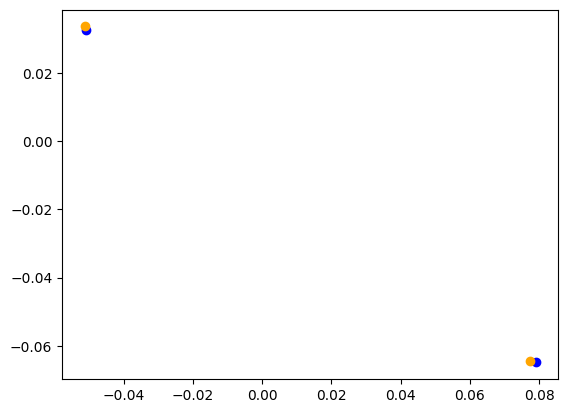

In [96]:
plt.scatter(old_centers[0][0],old_centers[0][1],color='b')
plt.scatter(old_centers[1][0],old_centers[1][1],color='b')
plt.scatter(new_centers[0][0],new_centers[0][1],color='orange')
plt.scatter(new_centers[1][0],new_centers[1][1],color='orange')

### Testing out the code 

In [93]:
# these are the iterations that the trade-off algorithm runs; note that beyond iteration 0, the starting clustering is no longer optimal in the optimization objective (for k-means, that means inertia)
no_of_iterations = 6
fairness_list = []
cost_list = []

# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 2 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k+1]]
print(i)


U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_copy = copy.deepcopy(y)
print(y_copy)



[1, 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]


In [94]:
[_,avgf] = compute_fairness_linear(G_SBM, list_nodes,k,y)
print("Average unfairness at C0: ", avgf)  

fairness_list.append(avgf)
[_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
print("Average cost at C0: ", avgcost)
cost_list.append(avgcost)
if avgf == 0:
    print("fairness is 0")
# generating G_new with double weights
G_new = nx.DiGraph()
G_new.add_nodes_from(G_SBM)
G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
list_nodes_Gnew = list(G_new.nodes())

length = {}
dis = {}
pre = {} 
result = SPFA2(G_new)

Average unfairness at C0:  32.470588235294116
Average cost at C0:  1.1903907713067448


In [95]:
result

'no negative cycle detected'

In [96]:
length = {}
dis = {}
pre = {} 

# we get to this point if we managed to fix the negative cycle (might have to run the previuos loop multiple times) or didn't have one to begin with
    
print("we're finding Mlow")

Mfind = 1
G_M = create_M_graph(G_SBM,G_new, Mfind)
mresult = SPFA(G_M)
if(len(mresult) != 3):
    Mfind = 0
    G_M = create_M_graph(G_SBM,G_new, Mfind)
    assert(len(SPFA(G_M)) == 3)
else:
    while True:
        G_M = create_M_graph(G_SBM,G_new, Mfind)
        if SPFA(G_M) == 'no negative cycle detected':
            break
        Mfind *= 2

# at this point, we perform a binary search 
# initialize M and the limits for the binary search
M = Mfind/2
delta = Mfind/2
low = Mfind/2
high = Mfind

# binary search to find M for which there is a cycle of length 0
termination_condition = 10e-12
mids = []
while np.abs(delta) > termination_condition:
    if high > low: 
        mid = (high + low) / 2
        mids.append(mid)
    G_M = create_M_graph(G_SBM,G_new, mid)
    if SPFA(G_M) == 'no negative cycle detected':
        delta = mid - low
        high = mid
    else:
        delta = high - mid
        low = mid
    print(delta)
whereinmidsweare = 0
for mm in reversed(mids):
    whereinmidsweare += 1
    G_M = create_M_graph(G_SBM,G_new, mm)
    if len(SPFA(G_M)) == 3:
        break
    if whereinmidsweare == len(mids):
        break
M=mm

G_M = create_M_graph(G_SBM,G_new, M)
[v,pre,stri]=SPFA(G_M)
# this is the best cycle that, if followed, will get us the next best clustering with the minimal ratio of cost loss to fairness/utility increase
myc = Trace(pre,v)
print("best cycle: ",myc)
ytest = np.copy(y)

myc2 = copy.deepcopy(myc)
# we 'follow' the best cycle in order to find that next best clustering, and will compute the cost and fairness/utility as we start the loop again in the next iteration
for i in range(len(myc)): 
    if type(myc[i]) == str:
        myc2[i] = list_nodes.index(myc[i])
for i in range(len(myc2)):
    print(myc2[i])
    if myc2[i] < len(G_SBM.nodes()):
        if i == len(myc2) - 1:
            break
        if myc2[i+1] < len(G_SBM.nodes()):
            #a = y[myc2[i]]
            ytest[myc2[i]] = y[myc2[i+1]]
        if myc2[i + 1] >= len(G_SBM.nodes()) and myc2[i+1] < len(G_SBM.nodes()) + k:
            print(myc2[i+1])
            ytest[myc2[i]] = myc2[i+1] % len(G_SBM.nodes())
y = np.copy(ytest)

we're finding Mlow
256.0
128.0
64.0
32.0
16.0
8.0
4.0
2.0
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
best cycle:  ['92', '222', '92']
67
106
67


### Now y = C1, compute the new fairness, cost, and check for neg cycles in the doubly weighted graph

In [97]:
[_,avgf] = compute_fairness_linear(G_SBM, list_nodes,k,y)
print("Average unfairness C1: ", avgf)  

fairness_list.append(avgf)
[_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
print("Average cost C1: ", avgcost)
cost_list.append(avgcost)

Average unfairness C1:  27.490196078431374
Average cost C1:  1.19544540455392


In [98]:
# generating G_new with double weights
G_new = nx.DiGraph()
G_new.add_nodes_from(G_SBM)
G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
list_nodes_Gnew = list(G_new.nodes())

length = {}
dis = {}
pre = {} 
result = SPFA2(G_new)

In [99]:
result

(127,
 {'1': '222',
  '55': '222',
  '205': '222',
  '272': '222',
  '494': '222',
  '779': '222',
  '894': '222',
  '3': '222',
  '28': '222',
  '147': '222',
  '407': '222',
  '674': '222',
  '884': '222',
  '27': '222',
  '63': '92',
  '173': '92',
  '202': '222',
  '327': '222',
  '353': '222',
  '429': '222',
  '441': '222',
  '492': '222',
  '545': '222',
  '32': '92',
  '440': '92',
  '624': '92',
  '797': '92',
  '920': '92',
  '151': '92',
  '277': '92',
  '502': '92',
  '866': '92',
  '45': '222',
  '48': '222',
  '79': '222',
  '335': '222',
  '496': '222',
  '601': '222',
  '765': '222',
  '46': '222',
  '117': '222',
  '196': '222',
  '257': '222',
  '268': '222',
  '170': '222',
  '252': '222',
  '883': '222',
  '61': '92',
  '125': '92',
  '70': '222',
  '101': '222',
  '132': '222',
  '240': '222',
  '425': '222',
  '447': '222',
  '72': '222',
  '857': '222',
  '80': '222',
  '120': '222',
  '285': '222',
  '468': '92',
  '85': '222',
  '190': '222',
  '213': '222',
  

In [100]:
iteration = 1

In [101]:
cost_list

[1.1903907713067448, 1.19544540455392]

In [104]:
fairness_list

[32.470588235294116, 27.490196078431374]

In [105]:
alpha = (cost_list[iteration-1] - cost_list[iteration]) / (fairness_list[iteration] - fairness_list[iteration - 1])
alpha += 2e-3
print("neg cycle, alpha is ", alpha)
print("compute metric with alpha for C0: ", cost_list[iteration-1] + alpha*fairness_list[iteration - 1])
print("compute metric with alpha for C1: ", cost_list[iteration] + alpha*fairness_list[iteration])

neg cycle, alpha is  0.0030149066756139297
compute metric with alpha for C0:  1.0924949780750455
compute metric with alpha for C1:  1.1125650288831215


In [90]:
myc

['92', '222', '92']

cluster 127 -> C_0 
cluster 128 -> C_1 
cluster 129 -> start 


In [65]:
G_new['222'][128]['auv']

KeyError: 128

In [91]:
# myc is the best cycle that we followed 
# compute m(myc)
m_myc = 0
for i in range(len(myc) - 1):
     m_myc += G_new[myc[i]][myc[i+1]]['tuv'] + alpha*G_new[myc[i]][myc[i+1]]['auv']
print(m_myc)

0.009960784313725317


### fixing a negative cycle until there are no more

In [112]:
# these are the iterations that the trade-off algorithm runs; note that beyond iteration 0, the starting clustering is no longer optimal in the optimization objective (for k-means, that means inertia)
no_of_iterations = 6
fairness_list = []
cost_list = []

# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 2 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k+1]]
print(i)


U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_copy = copy.deepcopy(y)
print(y_copy)


for iteration in range(no_of_iterations):
    print("Iteration number: ",iteration)
    # compute the cost and fairness of this clustering
    # using closeness utility
    #[_,avgf] = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y)
    # using statistical parity
    [_,avgf] = compute_fairness_linear(G_SBM, list_nodes,k,y)
    print("Average unfairness: ", avgf)  

    fairness_list.append(avgf)
    [_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
    print("Average cost: ", avgcost)
    cost_list.append(avgcost)
    if avgf == 0:
        break
    # generating G_new with double weights
    G_new = nx.DiGraph()
    G_new.add_nodes_from(G_SBM)
    G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y,k,X_dist)
    list_nodes_Gnew = list(G_new.nodes())

    length = {}
    dis = {}
    pre = {} 
    result = SPFA2(G_new)
    # assert that G_new does not have a negative t-cycle; if it does, then len(result) == 3 and then we 'perturb' the weights to get rid of this negative t-cycle
    if len(result) == 3:
        # if we are not at the initial clustering
        if iteration > 0:
            #my_slope = compute_slope(fairness_list[iteration-1], cost_list[iteration-1], fairness_list[iteration], cost_list[iteration])
            #myM = -1/my_slope
            #epsilon = myM*1e-60
            #print("M and slope:", M, myM)
            alpha = (cost_list[iteration-1] - cost_list[iteration]) / (fairness_list[iteration] - fairness_list[iteration - 1])
            alpha += 2e-3
            print("neg cycle, alpha is ", alpha)
            print("compute metric with alpha for C0: ", cost_list[iteration-1] + alpha*fairness_list[iteration - 1])
            print("compute metric with alpha for C1: ", cost_list[iteration] + alpha*fairness_list[iteration])
            for e in G_new.edges():
                
                #G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
                G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
                G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)
        # if we are actually at the initial clustering (SC is not the optimal one); can ignore
        #if iteration == 0:
            #my_slope = compute_slope(0.2, 0, fairness_list[iteration], cost_list[iteration])
            #myM = -1/my_slope
            #epsilon = myM*1e-60
            #print("M and slope:", M, myM)
            #for e in G_new.edges():
            #    G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
            #    G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)
                
    length = {}
    dis = {}
    pre = {} 
    newresult = SPFA2(G_new) 

    if len(newresult) == 3:
        [vv,pre,stri] = newresult
        negt = Trace(pre,vv)
        print(negt)
        sumcycle = 0
        t_weights_negt = []
        a_weights_negt = []
        for i in range(len(negt) - 1):
            sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
            t_weights_negt.append(G_new[negt[i]][negt[i+1]]['tuv'])
            a_weights_negt.append(G_new[negt[i]][negt[i+1]]['auv'])
        print("negative t-cycle was not fixed: ", sumcycle)
        print("neg cycle was not fixed, these are the weights: ", t_weights_negt, a_weights_negt)
        y_neg = np.copy(y)
        negt2 = copy.deepcopy(negt)
        for i in range(len(negt)): 
            if type(negt[i]) == str:
                negt2[i] = list_nodes.index(negt[i])
        for i in range(len(negt2)):
            if negt2[i] < len(G_SBM.nodes()):
                if i == len(negt2) - 1:
                    break
                if negt2[i+1] < len(G_SBM.nodes()):
                    y_neg[negt2[i]] = y[negt2[i+1]]
                if negt2[i + 1] >= len(G_SBM.nodes()) and negt2[i+1] < len(G_SBM.nodes()) + k:
                    y_neg[negt2[i]] = negt2[i+1] % len(G_SBM.nodes())
        _,avgdistneg = compute_avg_kdistance_inertia(y_neg, k, X_dist)
        # using closeness utility
        #_,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
        # using statistical parity
        _,avgfairnessneg = compute_fairness_linear(G_SBM, list_nodes,k,y_neg)
        print("Cost when correcting a negative cycle: ", avgdistneg)
        print("Fairness when correcting a negative cycle: ", avgfairnessneg)
        print("compute metric for following the neg cycle: ", avgdistneg + alpha*avgfairnessneg)

        #break

    # assert again that G_new does not have a negative t-cycle; if it does, then len(result) == 3 and then we see what clustering we get if we 'fix' the negative t-cycle
    # this is an example of a loop that 'fixes' negative cycles until there are no more (until we get to the optimal cycle in the objective set)
    if iteration > 0:
        while True:    
            G_new = nx.DiGraph()
            G_new.add_nodes_from(G_SBM)
            G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y_neg,k,X_dist)

            for e in G_new.edges():
                
                #G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
                G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
                G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)

            list_nodes_Gnew = list(G_new.nodes())

            length = {}
            dis = {}
            pre = {} 
            result = SPFA2(G_new)

            if len(result) > 3:
                break

            [vv,pre,stri] = result
            negt = Trace(pre,vv)
            print(negt)

            sumcycle = 0
            for i in range(len(negt) - 1):
                sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
            print("negative t-cycle was not fixed: ", sumcycle)
            y_neg2 = np.copy(y_neg)
            negt2 = copy.deepcopy(negt)
            for i in range(len(negt)): 
                if type(negt[i]) == str:
                    negt2[i] = list_nodes.index(negt[i])
            for i in range(len(negt2)):
                if negt2[i] < len(G_SBM.nodes()):
                    if i == len(negt2) - 1:
                        break
                    if negt2[i+1] < len(G_SBM.nodes()):
                        y_neg2[negt2[i]] = y_neg[negt2[i+1]]
                    if negt2[i + 1] >= len(G_SBM.nodes()) and negt2[i+1] < len(G_SBM.nodes()) + k:
                        y_neg2[negt2[i]] = negt2[i+1] % len(G_SBM.nodes())

            y_neg = copy.deepcopy(y_neg2)
            _,avgdistneg = compute_avg_kdistance_inertia(y_neg, k, X_dist)
            # using closeness utility
            #_,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
            # using statistical parity
            _,avgfairnessneg = compute_fairness_linear(G_SBM, list_nodes,k,y_neg)
            print("Cost when correcting a negative cycle: ", avgdistneg)
            print("Fairness when correcting a negative cycle: ", avgfairnessneg)
            print("compute metric for following the neg cycle: ", avgdistneg + alpha*avgfairnessneg)
        

    length = {}
    dis = {}
    pre = {} 

    # we get to this point if we managed to fix the negative cycle (might have to run the previuos loop multiple times) or didn't have one to begin with
     
    print("we're finding Mlow")

    Mfind = 1
    G_M = create_M_graph(G_SBM,G_new, Mfind)
    mresult = SPFA(G_M)
    if(len(mresult) != 3):
        Mfind = 0
        G_M = create_M_graph(G_SBM,G_new, Mfind)
        assert(len(SPFA(G_M)) == 3)
    else:
        while True:
            G_M = create_M_graph(G_SBM,G_new, Mfind)
            if SPFA(G_M) == 'no negative cycle detected':
                break
            Mfind *= 2

    # at this point, we perform a binary search 
    # initialize M and the limits for the binary search
    M = Mfind/2
    delta = Mfind/2
    low = Mfind/2
    high = Mfind

    # binary search to find M for which there is a cycle of length 0
    termination_condition = 10e-12
    mids = []
    while np.abs(delta) > termination_condition:
        if high > low: 
            mid = (high + low) / 2
            mids.append(mid)
        G_M = create_M_graph(G_SBM,G_new, mid)
        if SPFA(G_M) == 'no negative cycle detected':
            delta = mid - low
            high = mid
        else:
            delta = high - mid
            low = mid
        print(delta)
    whereinmidsweare = 0
    for mm in reversed(mids):
        whereinmidsweare += 1
        G_M = create_M_graph(G_SBM,G_new, mm)
        if len(SPFA(G_M)) == 3:
           break
    if whereinmidsweare == len(mids):
        break
    M=mm

    G_M = create_M_graph(G_SBM,G_new, M)
    [v,pre,stri]=SPFA(G_M)
    # this is the best cycle that, if followed, will get us the next best clustering with the minimal ratio of cost loss to fairness/utility increase
    myc = Trace(pre,v)
    print("best cycle: ",myc)
    ytest = np.copy(y)
    
    myc2 = copy.deepcopy(myc)
    # we 'follow' the best cycle in order to find that next best clustering, and will compute the cost and fairness/utility as we start the loop again in the next iteration
    for i in range(len(myc)): 
        if type(myc[i]) == str:
            myc2[i] = list_nodes.index(myc[i])
    for i in range(len(myc2)):
        print(myc2[i])
        if myc2[i] < len(G_SBM.nodes()):
            if i == len(myc2) - 1:
                break
            if myc2[i+1] < len(G_SBM.nodes()):
                #a = y[myc2[i]]
                ytest[myc2[i]] = y[myc2[i+1]]
            if myc2[i + 1] >= len(G_SBM.nodes()) and myc2[i+1] < len(G_SBM.nodes()) + k:
                print(myc2[i+1])
                ytest[myc2[i]] = myc2[i+1] % len(G_SBM.nodes())
    y = np.copy(ytest)

print("Fairness: ", fairness_list)
print("Cost: ", cost_list)
#filename = 'SBM_n' + str(len(list_nodes)) + '_r' + str(ratio) + '_k' + str(k) + 'closeness-test.csv'
#filename = 'Highschool_k' + str(k) + 'statparity_test.csv'
#f = open(filename,'w')
#writer=csv.writer(f,lineterminator="\n")
#writer.writerow(fairness_list)
#writer.writerow(cost_list)
#f.close()

[1, 2]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0]
Iteration number:  0
Average unfairness:  32.470588235294116
Average cost:  1.1903907713067448
we're finding Mlow
256.0
128.0
64.0
32.0
16.0
8.0
4.0
2.0
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.91038

In [20]:
# this is an example of a loop that 'fixes' negative cycles until there are no more (until we get to the optimal cycle in the objective set)
while True:    
    G_new = nx.DiGraph()
    G_new.add_nodes_from(G_SBM)
    G_new = doubly_weighted_G(G_SBM,G_new,list_nodes,y_neg,k,X_dist)
    list_nodes_Gnew = list(G_new.nodes())

    length = {}
    dis = {}
    pre = {} 
    result = SPFA2(G_new)

    if len(result) > 3:
        break

    [vv,pre,stri] = result
    negt = Trace(pre,vv)
    print(negt)

    sumcycle = 0
    for i in range(len(negt) - 1):
        sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
    print("negative t-cycle was not fixed: ", sumcycle)
    y_neg2 = np.copy(y_neg)
    negt2 = copy.deepcopy(negt)
    for i in range(len(negt)): 
        if type(negt[i]) == str:
            negt2[i] = list_nodes.index(negt[i])
    for i in range(len(negt2)):
        if negt2[i] < len(G_SBM.nodes()):
            if i == len(negt2) - 1:
                break
            if negt2[i+1] < len(G_SBM.nodes()):
                y_neg2[negt2[i]] = y_neg[negt2[i+1]]
            if negt2[i + 1] >= len(G_SBM.nodes()) and negt2[i+1] < len(G_SBM.nodes()) + k:
                y_neg2[negt2[i]] = negt2[i+1] % len(G_SBM.nodes())

    y_neg = copy.deepcopy(y_neg2)
    _,avgdistneg = compute_avg_kdistance_inertia(y_neg, k, X_dist)
    # using closeness utility
    #_,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
    # using statistical parity
    _,avgfairnessneg = compute_fairness_linear(G_SBM, list_nodes,k,y_neg)
    print("Cost when correcting a negative cycle: ", avgdistneg)
    print("Fairness when correcting a negative cycle: ", avgfairnessneg)

['845', '92', '845']
negative t-cycle was not fixed:  -0.006338780461233318
Cost when correcting a negative cycle:  1.1911696742660702
Fairness when correcting a negative cycle:  30.470588235294116
[129, '222', 128, 129]
negative t-cycle was not fixed:  -0.0007789029593255892
Cost when correcting a negative cycle:  1.1903907713067448
Fairness when correcting a negative cycle:  32.470588235294116


ValueError: too many values to unpack (expected 3)

In [22]:
len(result)

26

### Re-color the clusters found by spectral clustering, one all red and one all blue, to see how the algorithm changes 

In [57]:
# these are the iterations that the trade-off algorithm runs; note that beyond iteration 0, the starting clustering is no longer optimal in the optimization objective (for k-means, that means inertia)
no_of_iterations = 6
fairness_list = []
cost_list = []

# k is the number of clusters for spectral clustering
#k = len(sizes) # for simulated model
k = 2 # for the real data; needs to be varied


# computing the spectrum of the graph
A = nx.adjacency_matrix(G_SBM)
# computing the normalized Laplacian of the graph
L = nx.normalized_laplacian_matrix(G_SBM)
L.todense()
D = np.diag(np.sum(np.array(A.todense()), axis=1))

# computing the eigenvalues and eigenvectors of the normalized Laplacian
e, v = np.linalg.eig(L.todense())

# only take the first k sorted eigenvalues (can start from 0 or from 1, since first is 0 given that we have one connected component often times)
i = [list(e).index(j) for j in sorted(list(e))[1:k+1]]
print(i)


U = np.array(v[:, i])
# performing manual spectral clustering: using the first k values of the eigenspace to do k-means 
#km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0, random_state=3425)
km = KMeans(init='k-means++', n_clusters=k, max_iter=200, n_init=200, verbose=0)

km.fit(U)
y = km.labels_
# distances from the k-centers
X_dist = km.transform(U)**2

# keeping a copy of the clustering assignment
y_copy = copy.deepcopy(y)
print(y_copy)

[1, 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1
 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1]


In [58]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [43]:
G_SBM_recolor = copy.deepcopy(G_SBM)

In [44]:
for u in range(len(list_nodes)):
    if y[u] == 0:
        G_SBM_recolor.nodes[list_nodes[u]]['color'] = 'b'
    else:
        G_SBM_recolor.nodes[list_nodes[u]]['color'] = 'r'

In [51]:
G_SBM_recolor.nodes[list_nodes[3]]['color'] 

'b'

In [50]:
G_SBM.nodes[list_nodes[3]]['color'] 

'r'

In [36]:
y[0] == 0

True

In [37]:
list_nodes[0]

'1'

In [52]:

for iteration in range(no_of_iterations):
    print("Iteration number: ",iteration)
    # compute the cost and fairness of this clustering
    # using closeness utility
    #[_,avgf] = compute_util_avgprop_closeness(G_SBM_recolor, list_nodes,k,y)
    # using statistical parity
    [_,avgf] = compute_fairness_linear(G_SBM_recolor, list_nodes,k,y)
    print("Average unfairness: ", avgf)  

    fairness_list.append(avgf)
    [_,avgcost] = compute_avg_kdistance_inertia(y,k,X_dist)
    print("Average cost: ", avgcost)
    cost_list.append(avgcost)
    if avgf == 0:
        break
    # generating G_new with double weights
    G_new = nx.DiGraph()
    G_new.add_nodes_from(G_SBM_recolor)
    G_new = doubly_weighted_G(G_SBM_recolor,G_new,list_nodes,y,k,X_dist)
    list_nodes_Gnew = list(G_new.nodes())

    length = {}
    dis = {}
    pre = {} 
    result = SPFA2(G_new)
    # assert that G_new does not have a negative t-cycle; if it does, then len(result) == 3 and then we 'perturb' the weights to get rid of this negative t-cycle
    if len(result) == 3:
        # if we are not at the initial clustering
        if iteration > 0:
            #my_slope = compute_slope(fairness_list[iteration-1], cost_list[iteration-1], fairness_list[iteration], cost_list[iteration])
            #myM = -1/my_slope
            #epsilon = myM*1e-60
            #print("M and slope:", M, myM)
            alpha = (cost_list[iteration-1] - cost_list[iteration]) / (fairness_list[iteration] - fairness_list[iteration - 1])
            alpha += 2e-3
            print("neg cycle, alpha is ", alpha)
            for e in G_new.edges():
                
                #G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
                G_new[e[0]][e[1]]['tuv'] += alpha* G_new[e[0]][e[1]]['auv']
                G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)
        # if we are actually at the initial clustering (SC is not the optimal one); can ignore
        #if iteration == 0:
            #my_slope = compute_slope(0.2, 0, fairness_list[iteration], cost_list[iteration])
            #myM = -1/my_slope
            #epsilon = myM*1e-60
            #print("M and slope:", M, myM)
            #for e in G_new.edges():
            #    G_new[e[0]][e[1]]['tuv'] += G_new[e[0]][e[1]]['auv']/(myM+epsilon)
            #    G_new[e[0]][e[1]]['tuv'] = round(G_new[e[0]][e[1]]['tuv'],10)
                
    length = {}
    dis = {}
    pre = {} 
    newresult = SPFA2(G_new) 

    # assert again that G_new does not have a negative t-cycle; if it does, then len(result) == 3 and then we see what clustering we get if we 'fix' the negative t-cycle
    if len(newresult) == 3:
        [vv,pre,stri] = newresult
        negt = Trace(pre,vv)
        print(negt)
        sumcycle = 0
        for i in range(len(negt) - 1):
            sumcycle += G_new[negt[i]][negt[i+1]]['tuv']
        print("negative t-cycle was not fixed: ", sumcycle)
        y_neg = np.copy(y)
        negt2 = copy.deepcopy(negt)
        for i in range(len(negt)): 
            if type(negt[i]) == str:
                negt2[i] = list_nodes.index(negt[i])
        for i in range(len(negt2)):
            if negt2[i] < len(G_SBM_recolor.nodes()):
                if i == len(negt2) - 1:
                    break
                if negt2[i+1] < len(G_SBM_recolor.nodes()):
                    y_neg[negt2[i]] = y[negt2[i+1]]
                if negt2[i + 1] >= len(G_SBM_recolor.nodes()) and negt2[i+1] < len(G_SBM_recolor.nodes()) + k:
                    y_neg[negt2[i]] = negt2[i+1] % len(G_SBM_recolor.nodes())
        _,avgdistneg = compute_avg_kdistance_inertia(y_neg, k, X_dist)
        # using closeness utility
        #_,avgfairnessneg = compute_util_avgprop_closeness(G_SBM, list_nodes,k,y_neg)
        # using statistical parity
        _,avgfairnessneg = compute_fairness_linear(G_SBM_recolor, list_nodes,k,y_neg)
        print("Cost when correcting a negative cycle: ", avgdistneg)
        print("Fairness when correcting a negative cycle: ", avgfairnessneg)

        break

    length = {}
    dis = {}
    pre = {} 

    # we get to this point if we managed to fix the negative cycle (might have to run the previuos loop multiple times) or didn't have one to begin with
     
    print("we're finding Mlow")

    Mfind = 1
    G_M = create_M_graph(G_SBM_recolor,G_new, Mfind)
    mresult = SPFA(G_M)
    if(len(mresult) != 3):
        Mfind = 0
        G_M = create_M_graph(G_SBM_recolor,G_new, Mfind)
        assert(len(SPFA(G_M)) == 3)
    else:
        while True:
            G_M = create_M_graph(G_SBM_recolor,G_new, Mfind)
            if SPFA(G_M) == 'no negative cycle detected':
                break
            Mfind *= 2

    # at this point, we perform a binary search 
    # initialize M and the limits for the binary search
    M = Mfind/2
    delta = Mfind/2
    low = Mfind/2
    high = Mfind

    # binary search to find M for which there is a cycle of length 0
    termination_condition = 10e-12
    mids = []
    while np.abs(delta) > termination_condition:
        if high > low: 
            mid = (high + low) / 2
            mids.append(mid)
        G_M = create_M_graph(G_SBM_recolor,G_new, mid)
        if SPFA(G_M) == 'no negative cycle detected':
            delta = mid - low
            high = mid
        else:
            delta = high - mid
            low = mid
        print(delta)
    whereinmidsweare = 0
    for mm in reversed(mids):
        whereinmidsweare += 1
        G_M = create_M_graph(G_SBM_recolor,G_new, mm)
        if len(SPFA(G_M)) == 3:
           break
    if whereinmidsweare == len(mids):
        break
    M=mm

    G_M = create_M_graph(G_SBM_recolor,G_new, M)
    [v,pre,stri]=SPFA(G_M)
    # this is the best cycle that, if followed, will get us the next best clustering with the minimal ratio of cost loss to fairness/utility increase
    myc = Trace(pre,v)
    print("best cycle: ",myc)
    ytest = np.copy(y)
    
    myc2 = copy.deepcopy(myc)
    # we 'follow' the best cycle in order to find that next best clustering, and will compute the cost and fairness/utility as we start the loop again in the next iteration
    for i in range(len(myc)): 
        if type(myc[i]) == str:
            myc2[i] = list_nodes.index(myc[i])
    for i in range(len(myc2)):
        print(myc2[i])
        if myc2[i] < len(G_SBM_recolor.nodes()):
            if i == len(myc2) - 1:
                break
            if myc2[i+1] < len(G_SBM_recolor.nodes()):
                #a = y[myc2[i]]
                ytest[myc2[i]] = y[myc2[i+1]]
            if myc2[i + 1] >= len(G_SBM_recolor.nodes()) and myc2[i+1] < len(G_SBM_recolor.nodes()) + k:
                print(myc2[i+1])
                ytest[myc2[i]] = myc2[i+1] % len(G_SBM_recolor.nodes())
    y = np.copy(ytest)

print("Fairness: ", fairness_list)
print("Cost: ", cost_list)

Iteration number:  0
Average unfairness:  56.0
Average cost:  0.2561903917149986
we're finding Mlow
1024.0
512.0
256.0
128.0
64.0
32.0
16.0
8.0
4.0
2.0
1.0
0.5
0.25
0.125
0.0625
0.03125
0.015625
0.0078125
0.00390625
0.001953125
0.0009765625
0.00048828125
0.000244140625
0.0001220703125
6.103515625e-05
3.0517578125e-05
1.52587890625e-05
7.62939453125e-06
3.814697265625e-06
1.9073486328125e-06
9.5367431640625e-07
4.76837158203125e-07
2.384185791015625e-07
1.1920928955078125e-07
5.960464477539063e-08
2.9802322387695312e-08
1.4901161193847656e-08
7.450580596923828e-09
3.725290298461914e-09
1.862645149230957e-09
9.313225746154785e-10
4.656612873077393e-10
2.3283064365386963e-10
1.1641532182693481e-10
5.820766091346741e-11
2.9103830456733704e-11
1.4551915228366852e-11
7.275957614183426e-12
best cycle:  [129, '601', 128, 129]
129
37
128
128
129
Iteration number:  1
Average unfairness:  55.2112676056338
Average cost:  0.25682553263364405
neg cycle, alpha is  0.002805267950425506
['531', '232', 

### (Re-)compute centroids to see how much they shift  

In [78]:
def compute_centroids(G, list_nodes_G, no_clusters, cluster_assignment,myU):
    list_centroids = []
    for kk in range(no_clusters):
        list_centroids.append(myU[np.where(cluster_assignment==kk),:][0].mean(axis=0))
    return list_centroids

In [59]:
U[0]

array([-0.09065151,  0.07576987])

In [60]:
sums=np.sqrt(np.sum(np.square(U),axis=1)).reshape(-1,1)
T=U/sums

In [66]:
U

array([[-0.09065151,  0.07576987],
       [-0.07839108,  0.07176045],
       [-0.07641219,  0.07416726],
       [-0.10771685,  0.0896779 ],
       [-0.07486025,  0.06654638],
       [-0.07802022,  0.07651889],
       [-0.08792328,  0.07935799],
       [-0.08161343,  0.0491366 ],
       [-0.10430417,  0.0330627 ],
       [-0.10222715,  0.05091032],
       [-0.12728321,  0.04757702],
       [-0.05925706,  0.05127619],
       [-0.06374782,  0.03651916],
       [ 0.00552563, -0.01437407],
       [ 0.0396774 , -0.02011021],
       [ 0.03651708, -0.01963857],
       [-0.06801525,  0.03785513],
       [-0.10420171, -0.00185313],
       [-0.10975343,  0.00076009],
       [-0.10087906,  0.00645671],
       [-0.10499603,  0.00796095],
       [-0.02717378,  0.04687581],
       [-0.05815078,  0.02445837],
       [ 0.10740208, -0.03990279],
       [ 0.11615944, -0.04184782],
       [ 0.17078796, -0.0600471 ],
       [ 0.1648699 , -0.06051966],
       [ 0.09418435, -0.03525669],
       [ 0.14483175,

In [63]:
np.where(y==0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  16,  17,  18,  19,  20,  21,  22,  32,  33,  34,  35,  36,
         37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  61,  62,  63,  64,  65,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  83,  84,  85,  97,
         98, 100, 101, 103, 104, 106, 107, 108, 116, 117, 118]),)

In [68]:
U[np.where(y==0),:][0]

array([[-0.09065151,  0.07576987],
       [-0.07839108,  0.07176045],
       [-0.07641219,  0.07416726],
       [-0.10771685,  0.0896779 ],
       [-0.07486025,  0.06654638],
       [-0.07802022,  0.07651889],
       [-0.08792328,  0.07935799],
       [-0.08161343,  0.0491366 ],
       [-0.10430417,  0.0330627 ],
       [-0.10222715,  0.05091032],
       [-0.12728321,  0.04757702],
       [-0.05925706,  0.05127619],
       [-0.06374782,  0.03651916],
       [ 0.00552563, -0.01437407],
       [-0.06801525,  0.03785513],
       [-0.10420171, -0.00185313],
       [-0.10975343,  0.00076009],
       [-0.10087906,  0.00645671],
       [-0.10499603,  0.00796095],
       [-0.02717378,  0.04687581],
       [-0.05815078,  0.02445837],
       [-0.01861273,  0.07351064],
       [-0.02171597,  0.05711814],
       [-0.01861273,  0.07351064],
       [-0.0061464 ,  0.06187508],
       [-0.01263422,  0.06835131],
       [ 0.00836331,  0.06909211],
       [-0.0061464 ,  0.06187508],
       [-0.07833331,

In [70]:
U[np.where(y==0),:][0].mean(axis=0)

array([-0.0507766 ,  0.03258887])